In [0]:
!pip install lifelines
!pip install h2o 
!pip install imbalanced-learn
!pip install lime
!pip install pdpbox

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
%matplotlib inline
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
from imblearn.over_sampling import SMOTE
import sklearn.ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold, cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import roc_auc_score,f1_score
import h2o
from h2o.automl import H2OAutoML
import lime 
import lime.lime_tabular
from pdpbox import pdp, get_dataset, info_plots

## 1. Preliminary Analysis 

 ### 1.1  Inspected dataset


In [8]:
churn_df =pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_df.head()

customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0  7590-VHVEG  Female              0  ...          29.85        29.85     No
1  5575-GNVDE    Male              0  ...          56.95       1889.5     No
2  3668-QPYBK    Male              0  ...          53.85       108.15    Yes
3  7795-CFOCW    Male              0  ...          42.30      1840.75     No
4  9237-HQITU  Female              0  ...          70.70       151.65    Yes

[5 rows x 21 columns]

In [9]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


###  1.2 Changed data type of 'TotalCharges'


In [0]:
# Notice that TotalCharges column is in object data type. We need to change it back to float.
churn_df["TotalCharges"] = pd.to_numeric(churn_df["TotalCharges"],errors='coerce')

### 1.3  Filled missing values

In [11]:
# Count missing values
churn_df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [12]:
# Inspect the rows with missing value
churn_df[churn_df['TotalCharges'].isnull()]

customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
488   4472-LVYGI  Female              0  ...          52.55          NaN     No
753   3115-CZMZD    Male              0  ...          20.25          NaN     No
936   5709-LVOEQ  Female              0  ...          80.85          NaN     No
1082  4367-NUYAO    Male              0  ...          25.75          NaN     No
1340  1371-DWPAZ  Female              0  ...          56.05          NaN     No
3331  7644-OMVMY    Male              0  ...          19.85          NaN     No
3826  3213-VVOLG    Male              0  ...          25.35          NaN     No
4380  2520-SGTTA  Female              0  ...          20.00          NaN     No
5218  2923-ARZLG    Male              0  ...          19.70          NaN     No
6670  4075-WKNIU  Female              0  ...          73.35          NaN     No
6754  2775-SEFEE    Male              0  ...          61.90          NaN     No

[11 rows x 21 columns]

- From the inspection table above we could see that the missing values are probably due to system error. Because those customers all have 0 in 'tenure' column, which means they are all new customers. So I'll set every the missing value in 'TotalCharges' column equals to its 'MonthlyCharges'. 



In [0]:
idx = churn_df[churn_df['TotalCharges'].isnull()].index.tolist()
churn_df.loc[idx,'TotalCharges'] = churn_df.loc[idx,'MonthlyCharges']

## 2. EXPLORATORY DATA ANALYSIS
### 2.1 Explored categorical and numerical columns


In [0]:
categorical_columns = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService'
,'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling'
,'PaymentMethod','Churn']

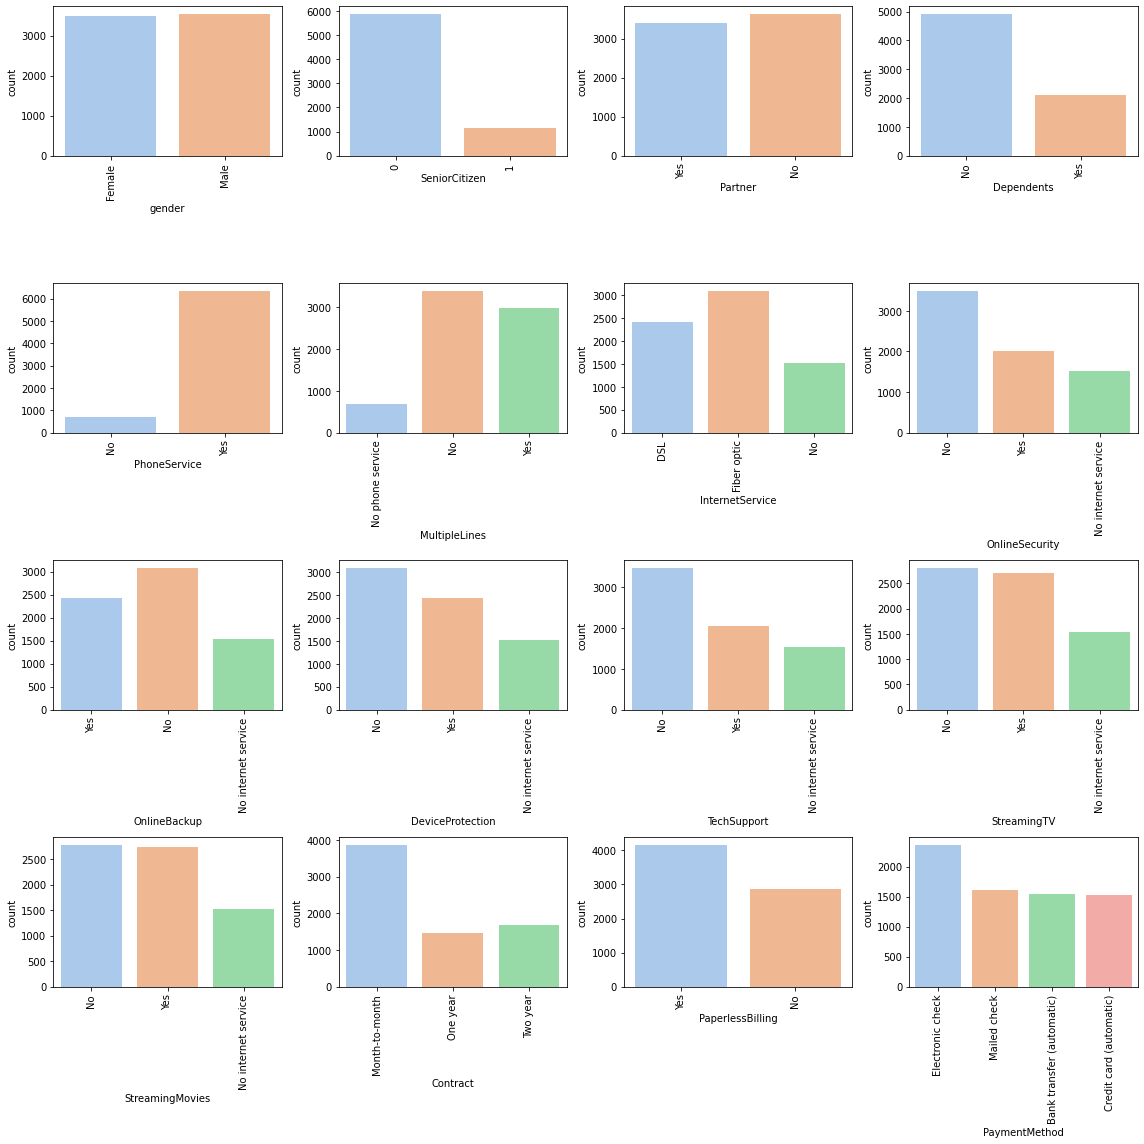

In [15]:
df_cat = churn_df[categorical_columns].copy()

plt.figure(figsize=(16,16))
for i in range(0,16):
        plt.subplot(4,4,i+1)
        sns.countplot(df_cat.iloc[:,i],palette = 'pastel')
        plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [0]:
def plot_distribution_num(data_select) : 
    sns.set_style("ticks")
    s = sns.FacetGrid(churn_df, hue = 'Churn',aspect = 1.5,palette = 'pastel')
    s.map(sns.kdeplot, data_select, shade = True, alpha = 0.8)
    s.set(xlim=(0, churn_df[data_select].max()))
    s.add_legend()
    s.set_axis_labels(data_select, 'proportion')
    s.fig.suptitle(data_select)
    plt.show()

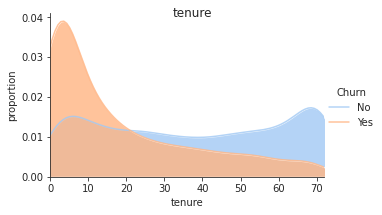

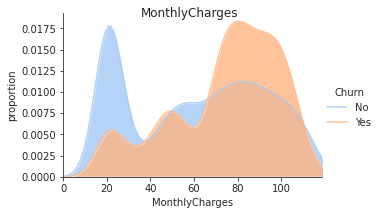

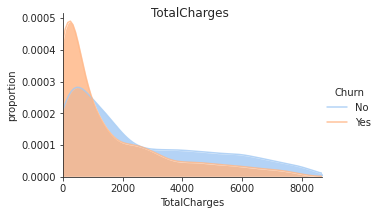

In [17]:
plot_distribution_num('tenure')
plot_distribution_num('MonthlyCharges')
plot_distribution_num('TotalCharges')

### 2.2 Target variable distribution
- Noticed the imbalanced distribution of target variable






In [18]:
trace = go.Pie(labels = ['Churn : no', 'Churn : yes'], values = churn_df['Churn'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict( colors=['lightblue','sandybrown'],
                           line=dict(color='#000000', width=1.5)))
layout = dict(title =  'Distribution of target variable', autosize=False, height = 300, width = 500)

fig = dict(data = [trace], layout=layout)
py.iplot(fig)

### 2.3 Transformed categorical columns using one hot encoding


In [0]:
# Prep Data: Remove non-predictive ID 
churn_df = churn_df.drop(columns='customerID',axis=1)

In [0]:
# Use one hot encoder to encode categorical varibles
churn_encoded = pd.get_dummies(churn_df)

In [0]:
# Drop column Churn_No
churn_encoded = churn_encoded.drop(columns='Churn_No',axis=1)

In [22]:
# Remove collinear features
#Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = churn_encoded.corr().abs()
corr_matrix.head()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove :' % (len(to_drop)))

to_drop

There are 12 columns to remove :


['gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'PaperlessBilling_Yes']

In [0]:
 churn_cleaned = churn_encoded.drop(columns = to_drop)

### 2.4 Survival Analysis
- Identified customer churn problem using survival analysis

Text(0.5, 0, 'Days after purchase')

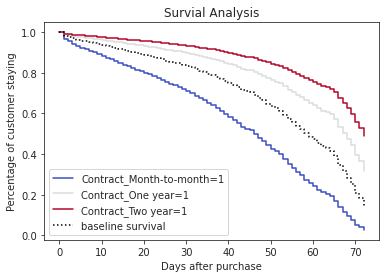

In [0]:
cph = CoxPHFitter(penalizer=0.1,l1_ratio=1.0)
cph.fit(churn_cleaned, duration_col='tenure', event_col='Churn_Yes')

cph.plot_covariate_groups(['Contract_Month-to-month','Contract_One year','Contract_Two year'], np.eye(3),cmap='coolwarm')
plt.title('Survial Analysis')
plt.ylabel('Percentage of customer staying')
plt.xlabel('Days after purchase')

-  Customer Churn Problem: More than 50% of Month-to-month contract customers leave the company after 50 days of purchase

### 3. Model Building
- Rsampled the imbalance dataset before model building
- Split the dataset before resample it, resample only the training set

In [24]:
x_train, x_test, y_train, y_test = train_test_split(churn_cleaned.drop(columns='Churn_Yes',axis=1), churn_cleaned['Churn_Yes'],
                                                  test_size = 0.3,
                                                  random_state=12)

sm = SMOTE(sampling_strategy='minority', random_state=7)
# Fit the model to generate the data.
oversampled_x_train, oversampled_y_train = sm.fit_sample(x_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_y_train), pd.DataFrame(oversampled_x_train)], axis=1)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



### 3.1 Random Forest Model with grid search

In [126]:
clf = RandomForestClassifier()
parameters = {'n_estimators': [1,5,10,100,200,500,1000,2000,5000],
              'min_samples_split': [10,100,1000]}

gs_rf = GridSearchCV(estimator= clf, param_grid = parameters,scoring = 'accuracy')
gs_rf.fit(oversampled_x_train,oversampled_y_train)

print("Best score: %0.3f" % gs_rf.best_score_)
print("Best parameters:", gs_rf.best_params_)

Best score: 0.842
Best parameters: {'min_samples_split': 10, 'n_estimators': 100}


In [127]:
sk_rf = clf.set_params(**gs_rf.best_params_)
sk_rf.fit(x_train, y_train)
cv = KFold(n_splits=5, shuffle=True) 
scoring = ['accuracy','f1', 'precision', 'recall', 'roc_auc']
for score in scoring:  
    scores = np.mean(cross_val_score(sk_rf, x_test, y_test,
                             scoring=score,
                             cv=cv))
    
    print('{} score: {}'.format(score, scores))

accuracy score: 0.7984101374743706
f1 score: 0.5434656626826435
precision score: 0.6368328643614753
recall score: 0.48350136438561647
roc_auc score: 0.8361032861151223


### 3.2 Logistic Regression with grid search




In [127]:
lr = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42)
parameters = {'C': [0.5,1, 1.3, 1.5,5,10]}
gs_lr = GridSearchCV(lr, param_grid = parameters, n_jobs=-1, cv=5, scoring="accuracy")
gs_lr.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.5, 1, 1.3, 1.5, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [128]:
print("Best score: %0.3f" % gs_lr.best_score_)
print("Best parameters:", gs_lr.best_params_)

Best score: 0.748
Best parameters: {'C': 0.5}


In [129]:
lr.set_params(**gs_lr.best_params_)
lr.fit(x_train, y_train)
cv = KFold(n_splits=5, shuffle=True) 
scoring = ['accuracy','f1', 'precision', 'recall', 'roc_auc']
for score in scoring:  
    scores = np.mean(cross_val_score(lr, x_test, y_test,
                             scoring=score,
                             cv=cv))    
    print('{} score: {}'.format(score, scores))

accuracy score: 0.7463356973995273
f1 score: 0.6119039500055158
precision score: 0.4957494549066664
recall score: 0.8122106591411589
roc_auc score: 0.8399955296156746


### 3.3 LightGBM model with random grid search

In [143]:
import lightgbm as lgbm
param_test = {'learning_rate' : [0.001,0.01, 0.1],
              'n_estimators' : [ 800, 1000, 1500, 2000, 3000, 5000],
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1,],
              'max_depth': [3, 4, 5, 6, 7],
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10],
              'reg_lambda': [0, 1e-1, 1, 2]}

#number of combinations
n_iter = 100

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=42, silent=True, metric='None', n_jobs=-1)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    scoring='accuracy',
    random_state=42,
    verbose=True)

grid_search.fit(x_train, y_train)
print('Best params: {} '.format(grid_search.best_params_))

opt_parameters =  grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.0min finished


Best params: {'reg_lambda': 1, 'reg_alpha': 7, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01} 


In [145]:
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)
lgbm_clf.fit(x_train, y_train)
cv = KFold(n_splits=5, shuffle=True) 
scoring = ['accuracy','f1', 'precision', 'recall', 'roc_auc']
for score in scoring:  
    scores = np.mean(cross_val_score(lgbm_clf, x_test, y_test,
                             scoring=score,
                             cv=cv))    
    print('{} score: {}'.format(score, scores))

accuracy score: 0.8064188318599935
f1 score: 0.5665811548419057
precision score: 0.6648803368805545
recall score: 0.512033921295251
roc_auc score: 0.8426995713834989


### 3.4 XGBoost Model with grid search

In [150]:
xgb = XGBClassifier( scale_pos_weight=(1 - churn_cleaned['Churn_Yes'].mean()), n_jobs =-1)
parameter = {'max_depth': [4,5,6,7,8],'n_estimators': [80,100,150,300],'learning_rate': [0.001,0.01, 0.1]}

grid = GridSearchCV(xgb, param_grid = parameter, cv= 5, scoring='accuracy')
grid.fit(x_train,y_train)

print("Best score: %0.3f" % grid.best_score_)
print("Best parameters:", grid.best_params_)


Best score: 0.800
Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}


In [151]:
xgb.set_params(**grid.best_params_)
xgb.fit(x_train, y_train)
cv = KFold(n_splits=5, shuffle=True) 
scoring = ['accuracy','f1', 'precision', 'recall', 'roc_auc']
for score in scoring:  
    scores = np.mean(cross_val_score(xgb, x_test, y_test,
                             scoring=score,
                             cv=cv))    
    print('{} score: {}'.format(score, scores))

accuracy score: 0.7898815726082037
f1 score: 0.5133572494766894
precision score: 0.6598224316382326
recall score: 0.42642445958856856
roc_auc score: 0.8330406263099303


In [25]:
glm=LogisticRegression(C=0.5, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False
                       )
glm.fit(x_train,y_train)

LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

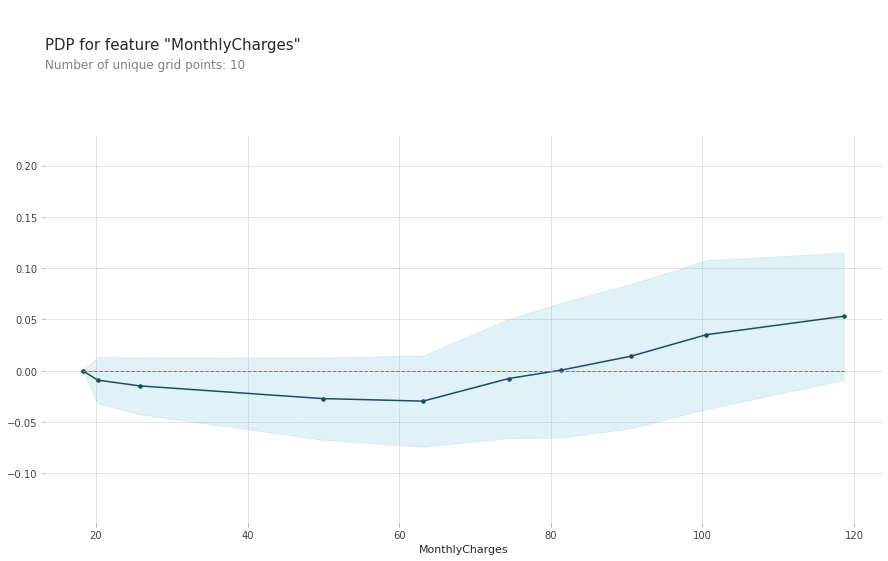

In [0]:
plot_pdp(sk_rf, x_test, 'MonthlyCharges')

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fca478c2710>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fca5e658a90>})

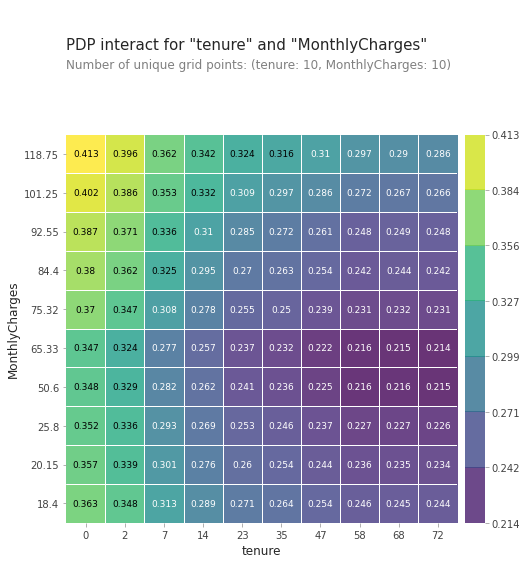

In [0]:
features_to_plot = ['tenure', 'MonthlyCharges']
inter1  =  pdp.pdp_interact(model=sk_rf, dataset=x_train, model_features=x_test.columns, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')

## 4. Built models using H2O and explain the best model using PDP and LIME

In [49]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         2 mins 40 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.0.3
H2O_cluster_version_age:    6 days
H2O_cluster_name:           H2O_from_python_unknownUser_5fi9jh
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.179 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.6.9 final
--------------------------  ------------------------------------------------------------------

- Convert H2O frame to numpy array
 - The LIME explainer requires numpy arrays as input and H2O requires the train and test data to be in H2O frames. 
 - In this case we could just use the train and test numpy arrays but for illustrative purposes here is how to convert an H2O frame to a pandas dataframe and a pandas dataframe to a numpy array.

In [0]:
data = churn_df
labels = data['Churn']
le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data.iloc[:,:-1].to_numpy()

In [0]:
categorical_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16]
categorical_names = {}
for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data[:, feature])
    data[:, feature] = le.transform(data[:, feature])
    categorical_names[feature] = le.classes_

In [0]:
data = data.astype(float)

In [0]:
feature_names = churn_df.columns.to_list()
feature_names = feature_names[:-1]

In [45]:
# Split train and test set
np.random.seed(1)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.70)


train_h2o_df = h2o.H2OFrame(train)
train_h2o_df.set_names(feature_names)
train_h2o_df['Churn'] = h2o.H2OFrame(labels_train)
train_h2o_df['Churn'] = train_h2o_df['Churn'].asfactor()


test_h2o_df = h2o.H2OFrame(test)
test_h2o_df.set_names(feature_names)
test_h2o_df['Churn'] = h2o.H2OFrame(labels_test)
test_h2o_df['Churn'] = test_h2o_df['Churn'].asfactor()



print(type(train_h2o_df))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
<class 'h2o.frame.H2OFrame'>


In [0]:
h2o_df = train_h2o_df.rbind(test_h2o_df)

In [0]:
for feature in categorical_features:
    train_h2o_df[feature] = train_h2o_df[feature].asfactor()
    test_h2o_df[feature] = test_h2o_df[feature].asfactor()

### 4.1 auroML model

In [67]:
# Build autoML model
aml = H2OAutoML(balance_classes = True,max_models = 10, seed = 123)
aml.train(feature_names, 'Churn', training_frame = train_h2o_df)
lb2 = aml.leaderboard
leader_model = aml.leader
perf = leader_model.model_performance(test_h2o_df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [68]:
print(perf.confusion_matrix())


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2723062379898573: 


0      1   Error             Rate
0      0  1241.0  344.0   0.217   (344.0/1585.0)
1      1   122.0  406.0  0.2311    (122.0/528.0)
2  Total  1363.0  750.0  0.2205   (466.0/2113.0)

In [71]:
print(perf.accuracy(thresholds=0.2723062379898573),perf.F1(thresholds=0.2723062379898573),perf.precision(thresholds=0.2723062379898573),perf.recall(thresholds=0.2723062379898573),perf.auc(),perf.logloss())

[[0.2723062379898573, 0.779460482725982]] [[0.2723062379898573, 0.6353677621283256]] [[0.2723062379898573, 0.5413333333333333]] [[0.2723062379898573, 0.7689393939393939]] 0.861931220724596 0.3963053915388875


### 4.2 Random Forest model

In [69]:

hyper_parameters = {'max_depth':[1,3,5,6,7,8,9,10,12,13,15,20,25,35]}

rf = H2ORandomForestEstimator(
    seed=42,
    stopping_rounds=5, 
    stopping_tolerance=1e-4, 
    stopping_metric="auc",
    model_id = 'rf'
    )

grid_id = 'depth_grid'

search_criteria = {'strategy': "Cartesian"}

#Grid Search
rf_grid = H2OGridSearch(model=rf, 
                        hyper_params=hyper_parameters, 
                        grid_id=grid_id, 
                        search_criteria=search_criteria)

rf_grid.train(feature_names, 'Churn', training_frame = train_h2o_df,validation_frame = test_h2o_df)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [70]:
sorted_rf_depth = rf_grid.get_grid(sort_by='auc',decreasing=True)
sorted_rf_depth.sorted_metric_table()

max_depth            model_ids                 auc
0            6   depth_grid_model_4  0.8585131679571743
1            5   depth_grid_model_3  0.8577627616862632
2            7   depth_grid_model_5  0.8573654526335914
3            9   depth_grid_model_7  0.8572035417264124
4            8   depth_grid_model_6  0.8571455883758723
5           10   depth_grid_model_8  0.8551064668769716
6            3   depth_grid_model_2  0.8509840120447375
7           12   depth_grid_model_9  0.8491641573463341
8           13  depth_grid_model_10  0.8472510993212886
9           15  depth_grid_model_11  0.8434363349584171
10          25  depth_grid_model_13  0.8409156629385336
11          35  depth_grid_model_14  0.8408989341363158
12          20  depth_grid_model_12  0.8408947519357614
13           1   depth_grid_model_1  0.8362483271197783

In [112]:
hyper_parameters = {"categorical_encoding" : ["one_hot_explicit"],
                    "histogram_type" : ["uniform_adaptive", "random", 
                                        "quantiles_global", "round_robin"],
                    "mtries" : [4, 5, 6, 7, 8], #Default = sqrt(p)
                    "nbins" : [10, 12, 15, 18, 20, 25, 30, 40, 50] #Default = 20
                   }

rf = H2ORandomForestEstimator(max_depth=6,
                              ntrees=50,
                              seed=42,
                              stopping_rounds=5, 
                              stopping_tolerance=1e-5, 
                              stopping_metric="auc",
                              model_id='rf'
    )

grid_id = 'rf_random_grid_'

search_criteria = { "strategy":"RandomDiscrete",
                    "max_models":100,
                    "max_runtime_secs":900,
                    "seed":42
        }

rf_grid = H2OGridSearch(model=rf, 
                        hyper_params=hyper_parameters, 
                        grid_id=grid_id, 
                        search_criteria=search_criteria)
rf_grid.train(feature_names, 'Churn', training_frame = train_h2o_df,validation_frame = test_h2o_df)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [113]:
sorted_rf_depth = rf_grid.get_grid(sort_by='f1',decreasing=True)
sorted_rf_depth.sorted_metric_table()

categorical_encoding  ...                  model_ids                  f1
0            OneHotExplicit  ...  rf_random_grid__model_125  0.6510219530658592
1            OneHotExplicit  ...  rf_random_grid__model_183  0.6509062253743105
2            OneHotExplicit  ...  rf_random_grid__model_126  0.6491904394757131
3            OneHotExplicit  ...  rf_random_grid__model_178  0.6489764973464747
4            OneHotExplicit  ...  rf_random_grid__model_140   0.648953301127214
..  ..                  ...  ...                        ...                 ...
195          SortByResponse  ...   rf_random_grid__model_30  0.6325925925925926
196             EnumLimited  ...   rf_random_grid__model_87  0.6325925925925926
197            LabelEncoder  ...   rf_random_grid__model_75  0.6319936958234831
198          SortByResponse  ...   rf_random_grid__model_10   0.630943396226415
199            LabelEncoder  ...   rf_random_grid__model_22  0.6304675716440423

[200 rows x 7 columns]

In [114]:
tuned_rf = sorted_rf_depth.models[0]
rf_perf = tuned_rf.model_performance(test_h2o_df)
print(rf_perf.confusion_matrix())


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32044158797515065: 


0      1   Error             Rate
0      0  1222.0  363.0   0.229   (363.0/1585.0)
1      1    98.0  430.0  0.1856     (98.0/528.0)
2  Total  1320.0  793.0  0.2182   (461.0/2113.0)

In [115]:
print(rf_perf.accuracy(thresholds = 0.32044158797515065),rf_perf.F1(thresholds =0.32044158797515065),
      rf_perf.precision(thresholds = 0.32044158797515065),rf_perf.recall(thresholds = 0.32044158797515065),rf_perf.auc(),rf_perf.logloss())

[[0.32044158797515065, 0.7818267865593942]] [[0.32044158797515065, 0.6510219530658592]] [[0.32044158797515065, 0.5422446406052963]] [[0.32044158797515065, 0.8143939393939394]] 0.8592020361342128 0.40277982519100874


### 4.3 GLM

In [83]:

# select the values for lambda_ to grid over
hyper_params = {"alpha": [0,0.1,0.01],
        "lambda": [0,0.1,0.01,0.001,0.0001]}
search_criteria = {
        "strategy":"RandomDiscrete",
        "max_models":200,
        "max_runtime_secs":300,
        "seed":123
        }

glm_model = H2OGeneralizedLinearEstimator(family= "binomial",lambda_search = True, balance_classes = True, seed = 123)
grid = H2OGridSearch(model = glm_model, hyper_params = hyper_params,
                    search_criteria = search_criteria)
grid.train(feature_names, 'Churn', training_frame = train_h2o_df,validation_frame = test_h2o_df)
# sort the grid models by decreasing AUC
grid_table = grid.get_grid(sort_by = 'f1', decreasing = True)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [85]:
grid_table.sorted_metric_table()

...                  f1
0     ...  0.6407438715131023
1     ...  0.6401354784081288
2     ...  0.6391752577319587
3     ...   0.636595744680851
4     ...  0.6351706036745406
5     ...  0.6349717969379532
6     ...  0.6347897774113768
7     ...  0.6341818181818182
8     ...  0.6341818181818182
9     ...  0.6341818181818182
10    ...  0.6337926033357505
11    ...  0.6337926033357505
12    ...  0.6337926033357505
13    ...  0.6337448559670782
14    ...  0.6337448559670782

[15 rows x 5 columns]

In [0]:
tuned_glm = grid_table.models[0]
glm_perf = tuned_glm.model_performance(test_h2o_df)
print(glm_perf.confusion_matrix())


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37041305603620817: 


0      1   Error             Rate
0      0  1309.0  276.0  0.1741   (276.0/1585.0)
1      1   149.0  379.0  0.2822    (149.0/528.0)
2  Total  1458.0  655.0  0.2011   (425.0/2113.0)

In [0]:
print(glm_perf.accuracy(thresholds = 0.37041305603620817),glm_perf.F1(thresholds = 0.37041305603620817),
      glm_perf.precision(thresholds = 0.37041305603620817),glm_perf.recall(thresholds = 0.37041305603620817),glm_perf.auc(),glm_perf.logloss())

[[0.37041305603620817, 0.7988641741599621]] [[0.37041305603620817, 0.6407438715131023]] [[0.37041305603620817, 0.5786259541984733]] [[0.37041305603620817, 0.7178030303030303]] 0.8541188700889015 0.41803139865108613


### 4.4 GBM

In [55]:

hyper_params = {'max_depth' : [3,4,5,6,7,8,9,10,12,13,15],
               }

gbm = H2OGradientBoostingEstimator(model_id='grid_gbm', ntrees=50,seed=123)

gbm_grid = H2OGridSearch(gbm, hyper_params,
                         grid_id = 'depth_gbm_grid',
                         search_criteria = {
                             "strategy":"Cartesian"})

gbm_grid.train(feature_names, 'Churn', training_frame = train_h2o_df,validation_frame = test_h2o_df)

sorted_gbm_depth = gbm_grid.get_grid(sort_by='auc',decreasing=True)
sorted_gbm_depth.sorted_metric_table()

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


max_depth                model_ids                 auc
0            3   depth_gbm_grid_model_1  0.8581242233056113
1            4   depth_gbm_grid_model_2  0.8579449861389924
2            5   depth_gbm_grid_model_3  0.8563222923238696
3            6   depth_gbm_grid_model_4  0.8533421757002199
4            7   depth_gbm_grid_model_5  0.8521054392505497
5            8   depth_gbm_grid_model_6  0.8468985995602715
6           10   depth_gbm_grid_model_8  0.8428878692285633
7            9   depth_gbm_grid_model_7  0.8411158111079247
8           12   depth_gbm_grid_model_9  0.8383221011375586
9           13  depth_gbm_grid_model_10  0.8358611748398814
10          15  depth_gbm_grid_model_11  0.8351746964917313

In [77]:
gbm = H2OGradientBoostingEstimator(max_depth=3, ntrees=50,seed=123, model_id='grid_gbm')

hyper_params_tune = {
                'sample_rate': [0.5,0.6,0.7,0.8,0.9,1],
                'col_sample_rate' : [0.5,0.6,0.7,0.8,0.9,1],
                'col_sample_rate_per_tree': [0.5,0.6,0.7,0.8,0.9,1],
                'col_sample_rate_change_per_level': [0.90,1.0,1.1],
                'learn_rate' : [.5, .25, 0.1, 0.07, 0.05, 0.01, 0.001],
                'nbins': [16,32,64],
                'nbins_cats': [16,32,64,128],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}

search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 900,  
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 123 }

random_grid = H2OGridSearch(model=gbm, hyper_params=hyper_params_tune,
                         grid_id = 'random_grid',
                         search_criteria =search_criteria_tune)

random_grid.train(feature_names, 'Churn', training_frame = train_h2o_df,validation_frame = test_h2o_df)


sorted_random_search = random_grid.get_grid(sort_by='f1',decreasing=True)
sorted_random_search.sorted_metric_table()

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


col_sample_rate  ...              model_ids                  f1
0                  0.5  ...  random_grid_model_196   0.649789029535865
1                  0.5  ...  random_grid_model_296   0.649789029535865
2                  0.5  ...  random_grid_model_163  0.6489444878811572
3                  0.5  ...  random_grid_model_263  0.6489444878811572
4                  0.7  ...   random_grid_model_83  0.6466165413533834
..  ..             ...  ...                    ...                 ...
294                0.7  ...  random_grid_model_100  0.6038011695906432
295                0.6  ...   random_grid_model_25   0.603071948261924
296                0.8  ...   random_grid_model_10  0.6003016591251885
297                0.6  ...    random_grid_model_1  0.5980167810831427
298                0.8  ...   random_grid_model_28  0.5976653696498054

[299 rows x 12 columns]

In [78]:
tuned_gbm=tuned_glm = sorted_random_search.models[0]

tuned_gbm.train(feature_names, 'Churn', training_frame = train_h2o_df,validation_frame = test_h2o_df)
gbm_perf = tuned_gbm.model_performance(test_h2o_df)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [79]:
print(gbm_perf.confusion_matrix())


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2770867377108122: 


0      1   Error             Rate
0      0  1184.0  401.0   0.253   (401.0/1585.0)
1      1    98.0  430.0  0.1856     (98.0/528.0)
2  Total  1282.0  831.0  0.2362   (499.0/2113.0)

In [66]:
print(gbm_perf.accuracy(thresholds = 0.2770867377108122),gbm_perf.F1(thresholds = 0.2770867377108122),
      gbm_perf.precision(thresholds = 0.2770867377108122),gbm_perf.recall(thresholds = 0.2770867377108122),gbm_perf.auc(),gbm_perf.logloss())

[[0.2770867377108122, 0.7638428774254614]] [[0.2770867377108122, 0.6328182487122884]] [[0.2770867377108122, 0.5174488567990373]] [[0.2770867377108122, 0.8143939393939394]] 0.8563222923238696 0.39426544260604696


### 4.5 Explainable Model - Using Lime

In [0]:
# Create a function to get prediction from H2O model
class h2o_predict_proba_wrapper:
    # the column_names is the labels of the X values
    def __init__(self,model,column_names):
            
            self.model = model
            self.column_names = column_names
 
    def predict_proba(self,this_array):        
        # If we have just 1 row of data we need to reshape it
        shape_tuple = np.shape(this_array)        
        if len(shape_tuple) == 1:
            this_array = this_array.reshape(1, -1)
            
        # We convert the numpy array that Lime sends to a pandas dataframe and
        # convert the pandas dataframe to an h2o frame
        self.pandas_df = pd.DataFrame(data = this_array,columns = self.column_names)
        self.h2o_df = h2o.H2OFrame(self.pandas_df)
        
        # Predict with the h2o drf
        self.predictions = self.model.predict(self.h2o_df).as_data_frame()
        # the first column is the class labels, the rest are probabilities for
        # each class
        self.predictions = self.predictions.iloc[:,1:].values
        return self.predictions

In [0]:
h2o_drf_wrapper = h2o_predict_proba_wrapper(tuned_rf,feature_names)

In [0]:
explainer = lime.lime_tabular.LimeTabularExplainer(train ,feature_names = feature_names,class_names=class_names,
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names)

In [101]:
i = 343
exp = explainer.explain_instance(test[i], h2o_drf_wrapper.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [84]:
i = 343
exp = explainer.explain_instance(test[i], h2o_drf_wrapper.predict_proba, num_features=5)
exp.show_in_notebook(show_all=False)

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


PartialDependencePlot progress: |█████████████████████████████████████████| 100%

PartialDependence: Partial Dependence Plot of model rf_random_grid__model_125 on column 'MonthlyCharges'


monthlycharges  mean_response  stddev_response  std_error_mean_response
0        18.250000       0.256966         0.187231                 0.002231
1        23.539474       0.256093         0.187055                 0.002229
2        28.828947       0.256203         0.186360                 0.002221
3        34.118421       0.254399         0.186266                 0.002219
4        39.407895       0.254487         0.186311                 0.002220
5        44.697368       0.255349         0.186492                 0.002222
6        49.986842       0.254916         0.186316                 0.002220
7        55.276316       0.254561         0.186130                 0.002218
8        60.565789       0.253015         0.186431                 0.002221
9        65.855263       0.253721         0.187970                 0.002240
10       71.144737       0.266041         0.198954                 0.002371
11       76.434211       0.269001         0.200215                 0.002386
12       81.723684       0.270648         0.201549                 0.002402
13       87.013158       0.271772         0.200948                 0.002394
14       92.302632       0.272107         0.200524                 0.002389
15       97.592105       0.277349         0.193136                 0.002301
16      102.881579       0.275354         0.187232                 0.002231
17      108.171053       0.276544         0.186215                 0.002219
18      113.460526       0.276182         0.186489                 0.002222
19      118.750000       0.278338         0.185121                 0.002206

[]

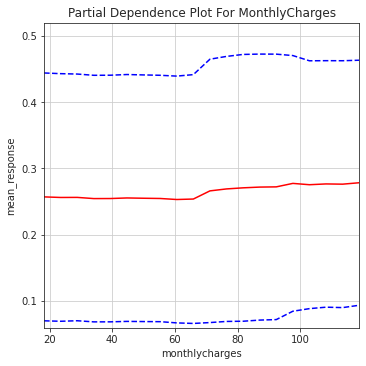

In [120]:
tuned_rf.partial_plot(data = h2o_df, cols = ["MonthlyCharges"],server=True, plot = True,nbins=20,figsize=(5,5))

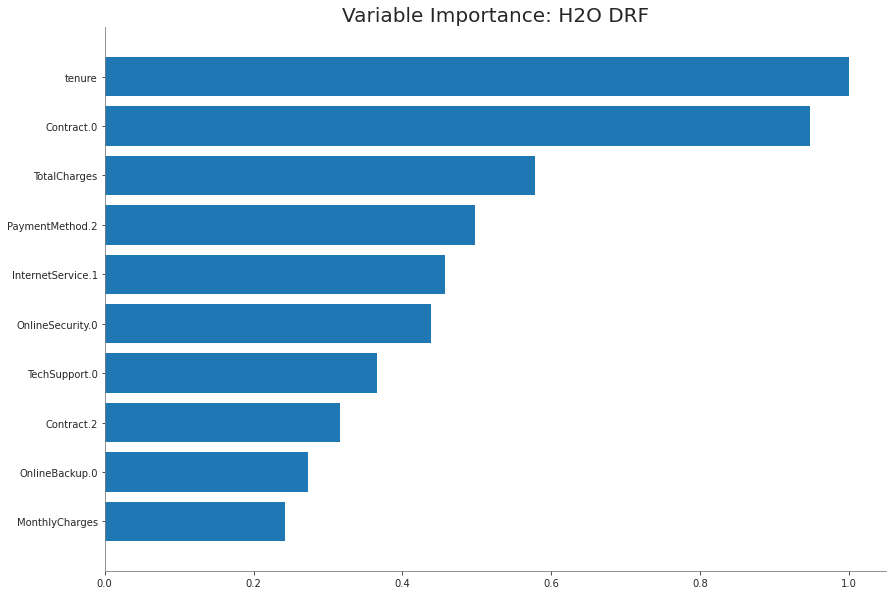

In [119]:
tuned_rf.varimp_plot()

In [106]:
h2o.shutdown(prompt=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

Deprecated, use ``h2o.cluster().shutdown()``.



H2O session _sid_bccb closed.
